In [2]:
# Necessary imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sn

In [4]:
!wget https://cernbox.cern.ch/remote.php/dav/public-files/yVs1E1XeCwu75Sl/archive.zip 

--2022-11-01 18:06:07--  https://cernbox.cern.ch/remote.php/dav/public-files/yVs1E1XeCwu75Sl/archive.zip
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.53.35, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155791278 (149M) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>] 148.57M  19.3MB/s    in 9.0s    

2022-11-01 18:06:22 (16.5 MB/s) - ‘archive.zip’ saved [155791278/155791278]



In [5]:
!wget https://cernbox.cern.ch/remote.php/dav/public-files/DlWVQE434BrKqlS/notumor.zip

--2022-11-01 18:06:22--  https://cernbox.cern.ch/remote.php/dav/public-files/DlWVQE434BrKqlS/notumor.zip
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.53.35, 128.142.53.28, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15828590 (15M) [application/zip]
Saving to: ‘notumor.zip’

notumor.zip         100%[===================>]  15.09M  8.29MB/s    in 1.8s    

2022-11-01 18:06:27 (8.29 MB/s) - ‘notumor.zip’ saved [15828590/15828590]



In [3]:
!ls

sample_data


In [6]:
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [7]:
!ls

archive.zip  notumor.zip  sample_data  Testing	Training


In [8]:
!unzip notumor.zip

Archive:  notumor.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_dataset/no/28 no.jpg  
  inflating: brain

In [9]:
!cp brain_tumor_dataset/no/*jpg Training/notumor/
!cp brain_tumor_dataset/no/*JPG Training/notumor/

In [10]:
xpixel = 128
ypixel = 128
numfilters_array = [64,128]
conv2D_kernel_size = 5
dense_layer_units = [256,128,64]
dropout_rate = 0.2

In [11]:
from keras import layers
def model_default(dropout_rate_val, numfilters, conv2D_kernel_size, dense_layer_units_val):
    inputs = layers.Input(shape=(xpixel,ypixel,1), name="input_mri")
    cnn = layers.Conv2D(32, conv2D_kernel_size, activation='relu')(inputs)
    cnn = layers.MaxPooling2D(pool_size=(2,2))(cnn)
    cnn = layers.BatchNormalization()(cnn)
    
    for num_filters in numfilters:
      cnn = layers.Conv2D(num_filters, conv2D_kernel_size, activation='relu')(cnn)
      cnn = layers.BatchNormalization()(cnn)
      cnn = layers.MaxPooling2D(pool_size=(2,2))(cnn)

    cnn = layers.Flatten()(cnn)

    for dense_units in dense_layer_units: 
      cnn = layers.Dense(units=dense_units, activation='relu')(cnn)
      cnn = layers.Dropout(dropout_rate)(cnn)

    output = layers.Dense(units=1, activation='sigmoid')(cnn)

    return keras.Model(inputs=inputs, outputs=output, name="cnn")
    
cnn = model_default(dropout_rate, numfilters_array, conv2D_kernel_size, dense_layer_units)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0001, clipvalue=0.5)
cnn.compile(optimizer=optimizer, loss='binary_crossentropy',
                   metrics= ['binary_accuracy'])

In [12]:
cnn.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_mri (InputLayer)      [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 124, 124, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 58, 58, 64)       256     

In [13]:
# using the ImageDataGenerator to prepare the images (Resize, nomalize, etc)

generator_train = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=False,
                                    vertical_flip=False) 

generator_test = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=False,
                                    vertical_flip=False)

In [ ]:
!nvidia-smi

Mon Oct 31 18:37:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    30W /  70W |  14632MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/content': ['.config', 'brain_tumor_dataset', 'notumor.zip', 'model_neuro_weights.h5', 'Testing', 'archive.zip', 'Training', 'yes', 'no', 'sample_data']


In [14]:
# Creating the train and test data.
batch = 64
train = generator_train.flow_from_directory('Training', target_size=(xpixel,ypixel),
batch_size=batch, class_mode= "binary", color_mode='grayscale')

test = generator_test.flow_from_directory('Testing', target_size=(xpixel,ypixel),
batch_size=batch, class_mode= "binary", color_mode='grayscale')

train.classes[train.classes == -1] = 1
train.classes[train.classes == 3] = 1
train.classes[train.classes == 1] = 1
train.classes[train.classes == 0] = 1
train.classes[train.classes == 2] = 0
test.classes[test.classes == -1] = 1
test.classes[test.classes == 3] = 1
test.classes[test.classes == 1] = 1
test.classes[test.classes == 0] = 1
test.classes[test.classes == 2] = 0

Found 5803 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [15]:
import numpy as np
print(np.sum(train.classes==0))

1686


In [16]:
path_weight = 'model_neuro_weights.h5'

In [19]:

# Creating callbacks for the model.
# If the model dosen't continue to improve (loss), the trainning will stop.

# Stop training if loss doesn't keep decreasing.
model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)

# Automatically saves the best weights of the model, based on best val_accuracy
model1_mcp = ModelCheckpoint(filepath = path_weight, monitor = 'val_binary_accuracy', 
                      save_best_only = True, verbose = 1)

# Fiting the model.
history1 = cnn.fit(train, steps_per_epoch=5712//batch, epochs=100, validation_data=test, validation_steps= 1311//batch,
                     callbacks=[model1_es, model1_rlr, model1_mcp])


Epoch 1/100
89/89 [==============================] - ETA: 0s - loss: 0.4184 - binary_accuracy: 0.8912
Epoch 1: val_binary_accuracy improved from -inf to 0.76172, saving model to model_neuro_weights.h5
89/89 [==============================] - 26s 181ms/step - loss: 0.4184 - binary_accuracy: 0.8912 - val_loss: 0.4882 - val_binary_accuracy: 0.7617 - lr: 0.0010
Epoch 2/100
89/89 [==============================] - ETA: 0s - loss: 0.1888 - binary_accuracy: 0.9438
Epoch 2: val_binary_accuracy did not improve from 0.76172
89/89 [==============================] - 16s 178ms/step - loss: 0.1888 - binary_accuracy: 0.9438 - val_loss: 0.8251 - val_binary_accuracy: 0.7039 - lr: 0.0010
Epoch 3/100
89/89 [==============================] - ETA: 0s - loss: 0.1424 - binary_accuracy: 0.9563
Epoch 3: val_binary_accuracy improved from 0.76172 to 0.86563, saving model to model_neuro_weights.h5
89/89 [==============================] - 16s 176ms/step - loss: 0.1424 - binary_accuracy: 0.9563 - val_loss: 0.3210 -

In [ ]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]


get_available_gpus()

['/device:CPU:0', '/device:GPU:0']

In [17]:
keras.models

<module 'keras.api._v2.keras.models' from '/usr/local/lib/python3.7/dist-packages/keras/api/_v2/keras/models/__init__.py'>

In [21]:
def display_learning_curves(h):
    fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5))

    ax1.plot(h.history["loss"])
    ax1.plot(h.history["val_loss"])
    ax1.legend(["train", "val"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("loss")
 #   ax2.plot(history.history["loss"])
 #   ax2.plot(history.history["mse"])
 #   ax2.legend(["train", "test"], loc="upper right")
 #   ax2.set_xlabel("Epochs")
 #   ax2.set_ylabel("loss")
    plt.show()


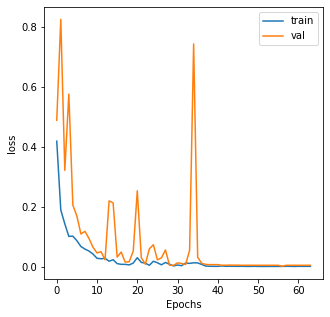

In [22]:
display_learning_curves(history1)

In [23]:
cnn.load_weights(path_weight)

In [24]:
prediction =cnn.predict(test)

21/21 [==============================] - 3s 123ms/step


In [25]:
print(prediction.shape)

(1311, 1)


In [26]:
prediction = np.reshape(prediction,1311)

In [27]:
print(prediction.shape)

(1311,)


2/2 [==============================] - 0s 7ms/step
0


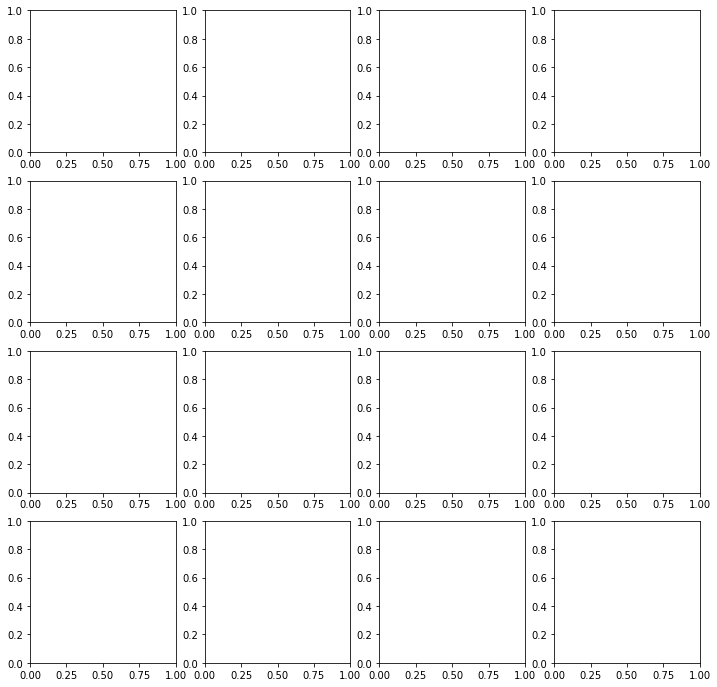

In [31]:
n_size = 4
fig, ax = plt.subplots(n_size,n_size,figsize=[n_size*3,n_size*3])
failed = 0
for index in range(len(test)+1):
    img, label = test.next() 
    result = cnn.predict(img).flatten()
    if(np.sum(np.round(result) != label) > 0):

        for image in range(len(label)):
            if (result[image]>0.015) != label[image]:
                if(failed < n_size**2):
                    ax[int(failed/n_size)][failed%n_size].imshow(np.reshape(img[image],(xpixel,ypixel)))
                    ax[int(failed/n_size)][failed%n_size].text(5,9,result[image],color='red')
                    ax[int(failed/n_size)][failed%n_size].text(6,19,label[image],color='red')
                failed += 1
print(failed)

2/2 [==============================] - 0s 8ms/step
59


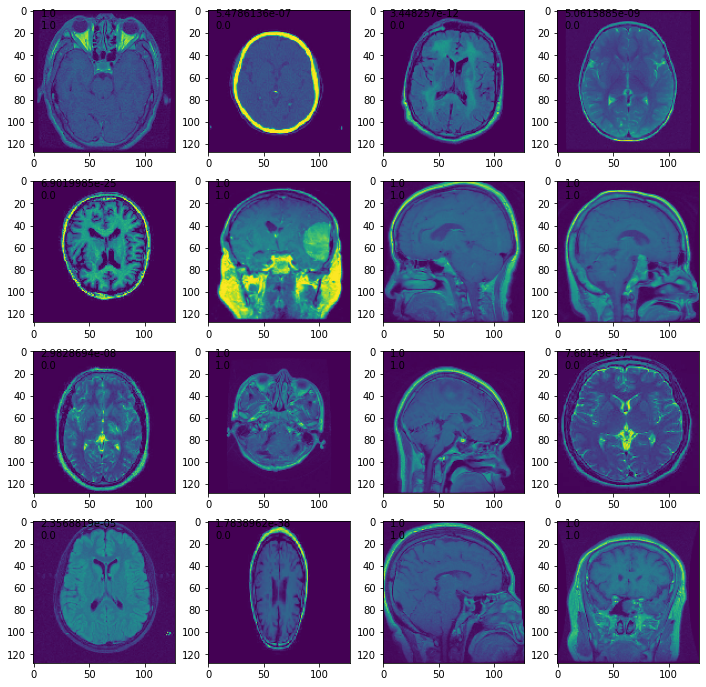

In [35]:
n_size = 4
fig, ax = plt.subplots(n_size,n_size,figsize=[n_size*3,n_size*3])
failed = 0
for index in range(len(test)):
    img, label = test.next() 
    result = cnn.predict(img).flatten()
    if(np.sum(np.round(result) != label) > 0):

        for image in range(len(label)):
            if (result[image] < 1) != label[image]:
                if(failed < n_size**2):
                    ax[int(failed/n_size)][failed%n_size].imshow(np.reshape(img[image],(xpixel,ypixel)))
                    ax[int(failed/n_size)][failed%n_size].text(6,5,result[image],color='black')
                    ax[int(failed/n_size)][failed%n_size].text(6,16,label[image],color='black')
                failed += 1
print(failed)